In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares

In [2]:
%matplotlib widget
# makes plots interactive 

In [2]:
sys.path.append("C:\\Users\josep\Downloads")

In [209]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [210]:
list(f.keys())

['DSV_00', 'U', 'Uk', 'eta', 'k', 't', 'x', 'y', 'z']

In [211]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
U = f.get('U')
Uk = f.get('Uk')

In [212]:
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
U = np.array(U)
Uk = np.array(Uk)

In [7]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Downloads\data_psi_zero.hdf5")

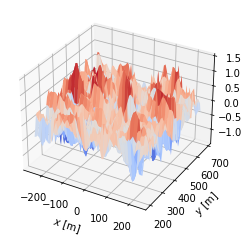

In [8]:
surf3d.plot_3d_surface()
plt.show()

In [9]:
spec3d = surf3d.define_SpectralAnalysis()
spec3d

## Transforming Data to Polars

In [10]:
len(t)

1200

In [11]:
kx_list = []
ky_list = []
# empty kx and ky lists for triplet values

thresh_freq = 1
max_freq = 2
step_size = 0.1
# Input frequencies values 

freqs = np.arange(thresh_freq, max_freq, step_size)

for f in freqs:
    i = np.argmin(np.abs(spec3d.w[len(t)//2:]-f))
    spec = spec3d.spectrum()
    spec_values = spec[len(t)//2 + i,:,:]
    # Gives the spectrum values represented by colour
    
    max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
    # Finds the specific index of the maximum value in spec_values
    
    max_kx = spec3d.kx[max_index[0]]
    max_ky = spec3d.ky[max_index[1]]
    # Finds the value of kx and ky corresponding to the maximum spectral density 
    
    kx_list.append(max_kx)
    ky_list.append(max_ky)

In [12]:
kx = np.array(kx_list)
kx

array([-0.0126933 ,  0.        , -0.02538661, -0.02538661,  0.12693304,
        0.06346652, -0.12693304,  0.08885313, -0.10154643, -0.13962634])

In [13]:
ky = np.array(ky_list)
ky

array([0.10154643, 0.12693304, 0.13962634, 0.16501295, 0.17770625,
       0.22847947, 0.20309286, 0.30463929, 0.29194598, 0.30463929])

In [14]:
r = np.sqrt( (kx)**2 + (ky)**2 )
r

array([0.10233669, 0.12693304, 0.14191545, 0.16695434, 0.21838385,
       0.23713048, 0.23949677, 0.31733259, 0.30910214, 0.33511283])

In [15]:
theta = np.arctan2(ky,kx)
theta

array([1.69515132, 1.57079633, 1.75064983, 1.72344566, 0.95054684,
       1.29984948, 2.12939564, 1.28700222, 1.90553316, 2.00055861])

In [16]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [17]:
z = f.get('z')
z_list = np.array(z)

In [18]:
U = f.get('U')
U_list = np.array(U)

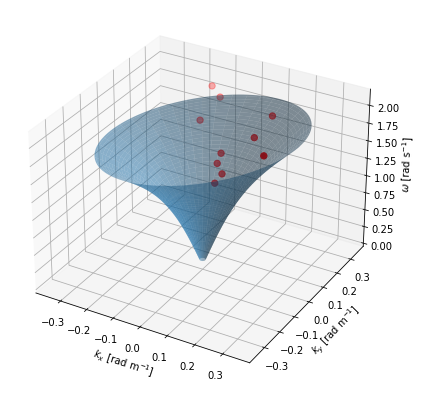

In [19]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')

plotting_interface.plot_disp_shell(axes, h=10, z = z_list, U = U_list, psi = 0)
axes.scatter(r*np.cos(theta), r*np.sin(theta), freqs, color='red', s=40)

In [20]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

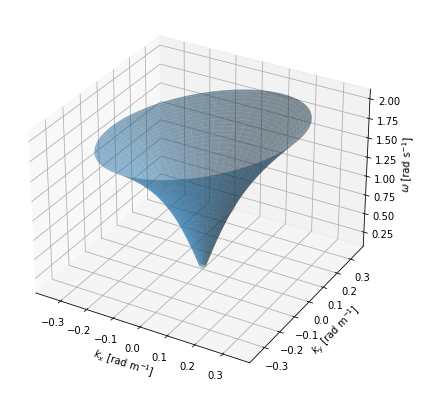

In [21]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=10, z = z_list, U = U_list, psi = 0)

In [22]:
disp_kx

array([[0.01      , 0.0099875 , 0.00995004, ..., 0.00996542, 0.00999449,
        0.00999859],
       [0.015     , 0.01498125, 0.01492506, ..., 0.01494813, 0.01499174,
        0.01499788],
       [0.02      , 0.01997501, 0.01990008, ..., 0.01993084, 0.01998899,
        0.01999717],
       ...,
       [0.335     , 0.33458134, 0.3333264 , ..., 0.3338416 , 0.33481556,
        0.33495264],
       [0.34      , 0.33957509, 0.33830142, ..., 0.33882431, 0.3398128 ,
        0.33995194],
       [0.345     , 0.34456884, 0.34327644, ..., 0.34380702, 0.34481005,
        0.34495123]])

In [23]:
disp_ky.shape

(68, 127)

In [24]:
disp_ww.shape

(68, 127)

In [25]:
matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
matrix_disp_r

array([[0.01 , 0.01 , 0.01 , ..., 0.01 , 0.01 , 0.01 ],
       [0.015, 0.015, 0.015, ..., 0.015, 0.015, 0.015],
       [0.02 , 0.02 , 0.02 , ..., 0.02 , 0.02 , 0.02 ],
       ...,
       [0.335, 0.335, 0.335, ..., 0.335, 0.335, 0.335],
       [0.34 , 0.34 , 0.34 , ..., 0.34 , 0.34 , 0.34 ],
       [0.345, 0.345, 0.345, ..., 0.345, 0.345, 0.345]])

In [26]:
disp_r = matrix_disp_r[:,0]
disp_r

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
       0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
       0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
       0.325, 0.33 , 0.335, 0.34 , 0.345])

In [27]:
matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
matrix_disp_theta

array([[ 0.        ,  0.05      ,  0.1       , ..., -0.08318531,
        -0.03318531,  0.01681469],
       [ 0.        ,  0.05      ,  0.1       , ..., -0.08318531,
        -0.03318531,  0.01681469],
       [ 0.        ,  0.05      ,  0.1       , ..., -0.08318531,
        -0.03318531,  0.01681469],
       ...,
       [ 0.        ,  0.05      ,  0.1       , ..., -0.08318531,
        -0.03318531,  0.01681469],
       [ 0.        ,  0.05      ,  0.1       , ..., -0.08318531,
        -0.03318531,  0.01681469],
       [ 0.        ,  0.05      ,  0.1       , ..., -0.08318531,
        -0.03318531,  0.01681469]])

In [28]:
disp_theta = matrix_disp_theta[0]
disp_theta

array([ 0.        ,  0.05      ,  0.1       ,  0.15      ,  0.2       ,
        0.25      ,  0.3       ,  0.35      ,  0.4       ,  0.45      ,
        0.5       ,  0.55      ,  0.6       ,  0.65      ,  0.7       ,
        0.75      ,  0.8       ,  0.85      ,  0.9       ,  0.95      ,
        1.        ,  1.05      ,  1.1       ,  1.15      ,  1.2       ,
        1.25      ,  1.3       ,  1.35      ,  1.4       ,  1.45      ,
        1.5       ,  1.55      ,  1.6       ,  1.65      ,  1.7       ,
        1.75      ,  1.8       ,  1.85      ,  1.9       ,  1.95      ,
        2.        ,  2.05      ,  2.1       ,  2.15      ,  2.2       ,
        2.25      ,  2.3       ,  2.35      ,  2.4       ,  2.45      ,
        2.5       ,  2.55      ,  2.6       ,  2.65      ,  2.7       ,
        2.75      ,  2.8       ,  2.85      ,  2.9       ,  2.95      ,
        3.        ,  3.05      ,  3.1       , -3.13318531, -3.08318531,
       -3.03318531, -2.98318531, -2.93318531, -2.88318531, -2.83

In [29]:
disp_theta.shape

(127,)

In [30]:
disp_ww[:,0].shape

(68,)

In [31]:
disp_ww

array([[0.09945258, 0.09945186, 0.09944972, ..., 0.0994506 , 0.09945226,
        0.0994525 ],
       [0.14925219, 0.14925064, 0.14924601, ..., 0.14924791, 0.14925151,
        0.14925201],
       [0.19890704, 0.19890439, 0.19889645, ..., 0.19889971, 0.19890588,
        0.19890674],
       ...,
       [2.04390997, 2.04361839, 2.04274439, ..., 2.0431032 , 2.04378151,
        2.04387699],
       [2.06268188, 2.06238393, 2.06149084, ..., 2.06185749, 2.06255062,
        2.06264818],
       [2.08136456, 2.08106021, 2.08014792, ..., 2.08052245, 2.08123047,
        2.08133013]])

In [32]:
r.shape

(10,)

In [33]:
freqs

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

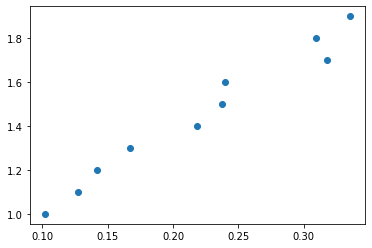

In [34]:
plt.scatter(r,freqs)

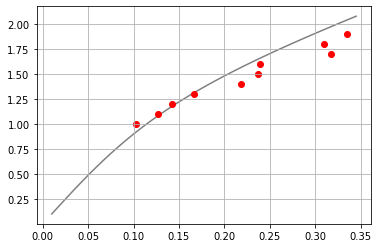

In [35]:
plt.scatter(r,freqs, color = 'red',  zorder=1)
plt.plot(disp_r,disp_ww[:,0], color='grey',zorder=0)
plt.grid(True)

## Make Into Function - Compares Altered Dispersion Relation and Triplet Points 

In [92]:
def plot_disp_relation_and_points_at_theta(spec_theta, thresh_freq, max_freq, step_size, h, z, U, psi):
    '''
    This function finds the relationship between triplets found from spectrum from FFT 
    and the dispersion relation at specific theta. 
    It plots it in the Radial vs Omega Space. 
    '''
    
    # (1) TRIPLET POINTS
    
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    # This gets the triplets points 
    # Triplets are (max_kx, mak_ky, freqs)
    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:]-f))
        spec = spec3d.spectrum()
        spec_values = spec[len(t)//2 + i,:,:]
        # Gives the spectrum values represented by colour
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
        
    kx = np.array(kx_list)
    ky = np.array(ky_list)
    
    # transform Triplets to polar coordinates
    r = np.sqrt( (kx)**2 + (ky)**2 )
    theta = np.arctan2(ky,kx)
    
    # (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]
    
    plt.scatter(r, freqs, color = 'red', zorder=1, label = 'Triplets')
    plt.plot(disp_r,disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation vs Triplets in Radial-Frequency Space")
    plt.legend()
    
    return r, theta, freqs, kx, ky

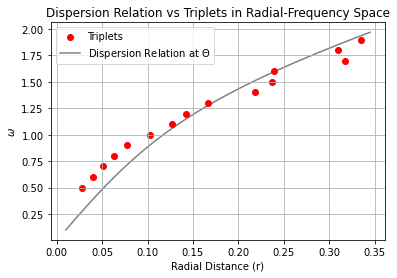

In [234]:
r, theta, freqs, kx, ky = plot_disp_relation_and_points_at_theta(1, thresh_freq = 0.5 , 
                                                  max_freq = 2, step_size = 0.1, h=10, 
                                                  z = z_list, U = U_list, psi = 0)

Relation between triplets and altered dispersion relation is relatively good. Thus, we can take the triplets to be the altered dispersion relation. So, now we need to compare to the orignial dispersion relation. 

## Compare Triplets to Original Dispersion Relation 

In [94]:
DWL_kx = np.arange(0.01, 0.35, 0.0001)
DWL_ky = np.arange(0.01, 0.35, 0.0001)
# DWL = deep water limit

In [95]:
DWL_omega = np.sqrt( 9.81 * np.sqrt( (DWL_kx)**2  + (DWL_ky)**2 ) )

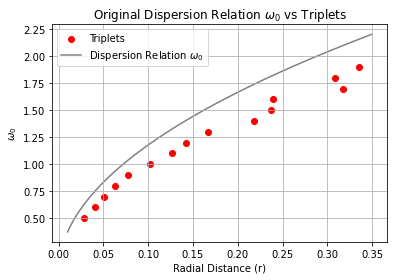

In [235]:
plt.scatter(r, freqs, color = 'red', zorder=1, label = 'Triplets')
plt.plot(DWL_kx, DWL_omega, color='grey',zorder=0, label = 'Dispersion Relation $\omega_{0}$')
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega_{0}$')
plt.title("Original Dispersion Relation $\omega_{0}$ vs Triplets")
plt.legend()

## Least Squares Fitting

In [132]:
# Find the value of DWL dispersion relation omega where the r values are closest to the DWL_kx values
near_indice = [np.argmin(np.abs(DWL_kx - rx)) for rx in r]

# Corresponding DWL_kx values
DWL_kx_values = DWL_kx[near_indice]
DWL_omega_values = DWL_omega[near_indice]

DWL_kx_values

array([0.0284, 0.0401, 0.0508, 0.0635, 0.0772, 0.1023, 0.1269, 0.1419,
       0.167 , 0.2184, 0.2371, 0.2395, 0.3173, 0.3091, 0.3351])

In [125]:
r

array([0.02838309, 0.04013975, 0.05077321, 0.06346652, 0.07721035,
       0.10233669, 0.12693304, 0.14191545, 0.16695434, 0.21838385,
       0.23713048, 0.23949677, 0.31733259, 0.30910214, 0.33511283])

In [134]:
freqs

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9])

In [135]:
DWL_omega_values

array([0.62769862, 0.7458718 , 0.83950611, 0.93859636, 1.0349054 ,
       1.1913238 , 1.32685301, 1.40308248, 1.52212472, 1.74067752,
       1.81366795, 1.8228241 , 2.09810413, 2.07081597, 2.15615122])

In [133]:
DWL_omega_values - freqs

array([0.12769862, 0.1458718 , 0.13950611, 0.13859636, 0.1349054 ,
       0.1913238 , 0.22685301, 0.20308248, 0.22212472, 0.34067752,
       0.31366795, 0.2228241 , 0.39810413, 0.27081597, 0.25615122])

In [162]:
theta

array([2.03444394, 1.24904577, 1.57079633, 1.57079633, 1.40564765,
       1.69515132, 1.57079633, 1.75064983, 1.72344566, 0.95054684,
       1.29984948, 2.12939564, 1.28700222, 1.90553316, 2.00055861])

In [171]:
# Objective function to be minimize
def objective(U,k,theta, DWL_omega_values, freqs):
    return DWL_omega_values - freqs + k*U*np.cos(theta)

# Initial guess for U
initial_U = np.zeros(len(r))

# Perform the least squares fit using least_squares
result = least_squares(objective, initial_U, args=(k, theta, DWL_omega_values, freqs))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)


Optimized U values: [ 10.06031517 -11.49202963   0.           0.         -10.62807769
  15.07281591   0.           7.99959101   8.74968104  -2.68391528
  -4.94225874   1.75544606  -4.48047413   2.66691769   1.83454798]


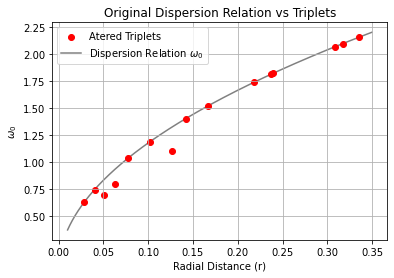

In [206]:
plt.scatter(r, freqs - k*optimized_U*np.cos(theta), color = 'red', zorder=1, label = 'Atered Triplets')
plt.plot(DWL_kx, DWL_omega, color='grey',zorder=0, label = 'Dispersion Relation $\omega_{0}$')
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega_{0}$')
plt.title("Original Dispersion Relation vs Triplets")
plt.legend()

In [222]:
sum(optimized_U)/len(optimized_U)
# Average Velcoity with all points included

0.9275039588471936

In [220]:
sum(optimized_U)/( len(optimized_U) - 3)
# Average Velocity with the 3 points that don't move removed

1.159379948558992

## Exploration of 3rd Data Point - Why doesn't it move?

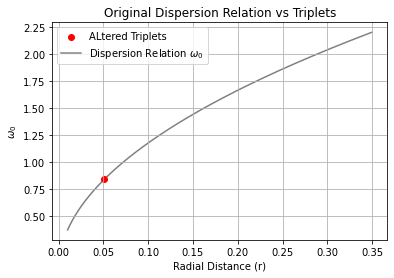

In [215]:
plt.scatter(r[2], freqs[2] + k[2]*4.7002771533723734*(10**16)*(np.cos(theta[2])), color = 'red', zorder=1, label = 'ALtered Triplets')
plt.plot(DWL_kx, DWL_omega, color='grey',zorder=0, label = 'Dispersion Relation $\omega_{0}$')
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega_{0}$')
plt.title("Original Dispersion Relation vs Triplets")
plt.legend()

In [216]:
k[2]

0.050773214603471395

In [217]:
np.cos(theta[2])

6.123233995736766e-17

In [218]:
DWL_omega_values[2]

0.8395061050293224

In [219]:
DWL_omega_values[2]/ ( np.cos(theta[2]) * k[2] )

2.7002771533723734e+17